# MIT Reactor Data Set Example

**Inputs**: Control rod heights

**Outputs**: Pin power

To demonstrate pyMAISE, models are produced on an MIT reactor data set representing the institution's light-water-cooled 6MW thermal power reactor. The figure below shows the core contains 22 fuel elements, 5 locations for in-core experiments, with 6 control blades surrounding them. The data set is used to find a relationship between the 6 control blade heights and the power produced by the 22 fuel elements in the core. Therefore, the data set is constructed by perturbing the depths of the control blades in the reactor. The corresponding output results in the power levels for each of the 22 fuel elements. The data was generated using Monte Carlo simulation by the MCNP code, where the dataset size includes 1000 simulations/samples [1]. The goal is to use pyMAISE to build, tune, and compare various ML models in their performance in predicting the core power distribution based on the control blade insertion depth.

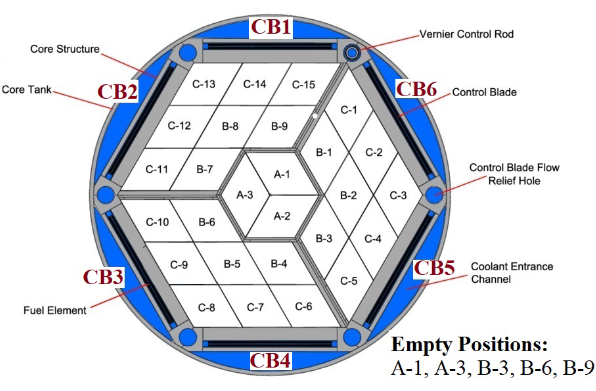

In [25]:
import pyMAISE as mai
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from scipy.stats import uniform, randint
from sklearn.model_selection import ShuffleSplit

# Plot settings
matplotlib_settings = {
    "font.size": 14,
    "legend.fontsize": 12,
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

Starting any pyMAISE job requires initialization, this includes the definition of global settings used throughout pyMAISE. These settings include:

- `verbosity`: How much pyMAISE outputs to the terminal.
- `random_state`: Some models use pseudo random algorithms during training. To create the same models every run, `random_state` must be defined.
- `test_size`: Defines the fraction of the data used for model testing.
- `num_configs_saved`: Of the large number of hyper-parameter configurations, only the top `num_configs_saved` are returned.

A dictionary of these settings are then passed to the settings class of pyMAISE during initialization. In this instance the defaults of pyMAISE are used so nothing is passed to `settings.init()`.

In [7]:
global_settings = mai.settings.init()

## Data Loading and Pre-Processing

pyMAISE comes with several benchmarking data sets with this MIT reactor data set. Each data set has its own loading function which returns a `PreProcessor` object with the data loaded. For personal data, initialize the `PreProcessor` with the following

`preprocessor = mai.PreProcessor("path/to/data.csv", slice(0, x), slice(x, y))`

for one file with both inputs and outputs. Here `x` defines the beginning of the outputs and `y` defines the end $+1$ position of the outputs of the data set. For data with inputs and outputs in seperate files use the following

`preprocessor = mai.PreProcessor(["path/to/input.csv", "path/to/output.csv"])`.

As stated the MIT reactor data set has a provided loading function, `load_MITR()`.

In [8]:
preprocessor = mai.load_MITR()

The MIT reactor data set has 6 inputs; one for each control rod position:

In [9]:
preprocessor.inputs.head()

,CR1,CR2,CR3,CR4,CR5,CR6
0,25.959917,22.949372,20.853175,24.669168,20.481047,25.357266
1,21.753868,25.360626,20.588530,20.110872,27.467110,25.816585
2,27.429199,23.570180,27.596307,26.390445,23.996037,24.611822
3,21.788159,24.289480,25.195061,23.462239,25.314196,21.665092
4,20.651764,26.309493,24.645944,25.897686,23.748592,26.946972


and 22 fuel element power outputs:

In [10]:
preprocessor.outputs.head()

,A-2,B-1,B-2,B-4,B-5,B-7,B-8,C-1,C-2,C-3,...,C-6,C-7,C-8,C-9,C-10,C-11,C-12,C-13,C-14,C-15
0,25930.916138,22958.314941,21725.516357,22799.333618,21815.979675,22785.586487,21279.806152,18421.966827,18484.818298,18886.733154,...,18784.499451,18171.291687,18604.801849,18593.999756,19458.648743,18113.577637,17390.992249,17912.014526,18207.042603,19089.969421
1,25883.078125,22856.061951,21602.108765,22721.063293,21698.868164,22916.184875,21447.282837,17945.424408,17894.501221,18588.017639,...,18727.330261,18035.394409,18114.253510,18005.816956,19148.114197,18807.224915,18331.525757,18699.555573,18381.290527,19052.587830
2,25672.208252,22584.910950,21419.950256,22721.304749,21802.134827,22572.159546,20975.878662,18184.984711,18316.332275,18761.267548,...,19440.091980,18987.642334,19354.132843,18791.702271,19605.605347,18351.250732,17572.990784,17878.914185,17831.210449,18702.889954
3,25897.859375,22661.180420,21529.638977,22943.255249,21972.662415,22834.193054,21179.314453,17646.767395,17705.476135,18429.696381,...,19395.144714,18863.283508,19052.659454,18591.373230,19532.076660,18663.584961,17934.262787,17923.863403,17608.497009,18401.561340
4,25761.079712,22576.364319,21405.163879,22783.927185,21851.152466,22721.955627,21140.955383,17564.821411,17507.742371,18373.703308,...,19245.952881,18686.140686,19088.561737,18763.566223,19647.963135,18462.088745,17718.471191,18201.529053,18189.525635,18834.598328


To get a better understanding of this data set lets plot a correlation matrix of the data.

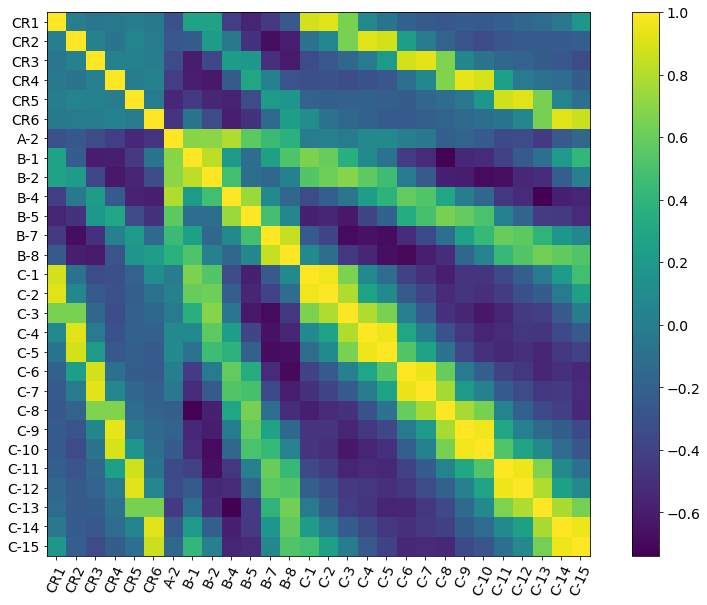

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
fig, ax = preprocessor.correlation_matrix(fig=fig, ax=ax)

There is a large positive corrilation between the rod positions and the outer fuel assemblies (C-1 to C15).

With the data loaded it can now be pre-processed by min-max, standard, or no scaling through the following functions:

- `preprocessor.min_max_scale()`: Scale based on the minimum and maximum data points in a feature.
- `preprocessor.std_scale()`: Standard scale the data.
- `preprocessor.data_split()`: No scaling.

All three return a tuple of training and testing data, `(xtrain, xtest, ytrain, ytest)`. Both `min_max_scale()` and `std_scale()` can scale input and/or output data depending on how `scale_x` and `scale_y` are defined. To min-max scale only the inputs run `preprocessor.min_max_scale(scale_y=False)`. For the MIT reactor data set both inputs and outputs are min-max scaled.

In [14]:
data = preprocessor.min_max_scale()

## Model Initialization

pyMAISE supports both classical ML methods and dense sequential neural networks. Here is a list of all the models supported and their corresponding names in pyMAISE:

- Linear regression: `linear`,
- Lasso regression: `lasso`,
- Support vector regression: `svr`, $\rightarrow$ *Only works for 1D outputs; therefore, it is not explored in this data set.*
- Decision tree regression: `dtree`,
- Random forest regression: `rforest`,
- K-nearest neighbors regression: `knn`,
- Neural networks: `nn`,

Prior to hyper-parameter tuning all models under investigation must be initialized. To define the models of interest list their names in the `models` list. Then define a dicitonary within the `model_settings` dictionary with the initial guess (if you plan to use random or Bayesian search) and defaults for each model. Not all model settings must be defined as their defaults match the original scikit-learn or Keras settings. If the defaults satisfy your initial guess then a dictionary of settings is not necessary. Use the MIT reactor data set model settings as a reference:

In [15]:
model_settings = {
    "models": ["linear", "lasso", "dtree", "knn", "rforest", "nn"],
    "nn": {
        # Sequential
        "num_layers": 4,
        "dropout": True,
        "rate": 0.5,
        "validation_split": 0.15,
        "loss": "mean_absolute_error",
        "metrics": ["mean_absolute_error"],
        "batch_size": 8,
        "epochs": 50,
        "warm_start": True,
        "jit_compile": False,
        # Starting Layer
        "start_num_nodes": 100,
        "start_kernel_initializer": "normal",
        "start_activation": "relu",
        "input_dim": preprocessor.inputs.shape[1], # Number of inputs
        # Middle Layers
        "mid_num_node_strategy": "linear", # Middle layer nodes vary linearly from 'start_num_nodes' to 'end_num_nodes'
        "mid_kernel_initializer": "normal",
        "mid_activation": "relu",
        # Ending Layer
        "end_num_nodes": preprocessor.outputs.shape[1], # Number of outputs
        "end_activation": "linear",
        "end_kernel_initializer": "normal",
        # Optimizer
        "optimizer": "adam",
        "learning_rate": 5e-4,
    },
}
tuning = mai.Tuning(data=data, model_settings=model_settings)

## Hyper-parameter Tuning

Three hyper-parameter tuning functions are supported: grid, random, and Bayesian search. Using lists or Numpy arrays, a grid of hyper-parameter configurations of interest can be used in grid and Bayesian search. While the Bayesian search function takes in the same dictionary as grid search, the function only uses the minimum and maximum value of the array in the case of numbers. For random search the parameter distributions can also be defined as Numpy arrays or lists; however, Scipy distributions can also be used to define different sampling distributions for continuous functions. For the MIT reactor data set a random search strategy is used for the classical methods and a Bayesian search for the neural networks. `linear` is not defined in the `random_search_dist` but is provided in the `models` input parameter in `random_search`. This results in a manual fit of `linear` as defined in the previous section.

Additionally, 5-fold `ShuffleSplit` cross-validation (CV) is used for the classical models and 5-fold CV is used for the neural networks. During training each hyper-parameter configuration of a model is trained and tested on 5-folds or portions of the training data set. This results in a greater number of models developed but these models are more robust and resistant to bias in the data set.

In [16]:
random_search_spaces = {
    "lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "dtree": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "rforest": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "knn": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
bayesian_search_spaces = {
    "nn": {
        "mid_num_node_strategy": ["constant", "linear"],
        "batch_size": [8, 64],
        "learning_rate": [1e-5, 0.001],
        "num_layers": [2, 6],
        "start_num_nodes": [25, 300],
    },
}

start = time.time()
random_search_configs = tuning.random_search(
    param_spaces=random_search_spaces, 
    models=["linear"] + list(random_search_spaces.keys()), 
    n_iter=300, 
    cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=global_settings.random_state),
)
bayesian_search_configs = tuning.bayesian_search(
    param_spaces=bayesian_search_spaces,
    models=bayesian_search_spaces.keys(),
    n_iter=50,
    cv=5,
)
stop = time.time()
print("Hyper-parameter tuning took " + str((stop - start) / 60) + " minutes to process.")

Hyper-parameter tuning search space was not provided for linear, doing manual fit
Hyper-parameter tuning took 88.09553459088008 minutes to process.


With the conclusion of training we can see training results for each iteration using the `convergence_plot` function. For example here is Bayesian search of neural networks:

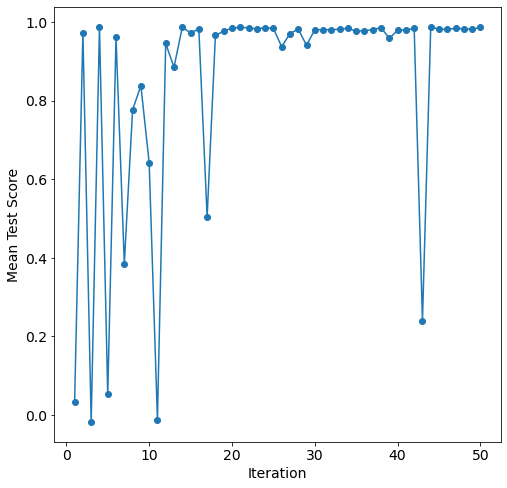

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuning.convergence_plot(model_types="nn")

The Bayesian search overall improves performance as it optimizes the neural network hyper-parameters.

## Model Post-processing

With the models tuned and the top `num_configs_saved` saved, we can now pass these models to the `PostProcessor` for model comparison and analysis. Additionally if you wish to update some hyper-parmeters, a dictionary similar to model initialization can be passed.

In [18]:
new_model_settings = {
    "nn": {"epochs": 200}
}
postprocessor = mai.PostProcessor(
    data=data, 
    models_list=[random_search_configs, bayesian_search_configs], 
    new_model_settings=new_model_settings
)

The models can now be output using the `metrics` function in the `PostProcessor`. This returns an ordered table with training and testing $R^2$, mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE). By default these models are ordered by descending test $R^2$; however, it can also be ordered along other metrics using the `sort_by` parameter of `metrics`. For all but the $R^2$ the data presented is ascending.  

In [19]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
0,linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.994918,0.010278,0.000209,0.014444,0.994887,0.010257,0.000204,0.014282
1,lasso,{'alpha': 0.00013933518715436062},0.994884,0.010434,0.000210,0.014492,0.994841,0.010446,0.000206,0.014343
2,lasso,{'alpha': 0.0001579320048854062},0.994875,0.010461,0.000210,0.014505,0.994830,0.010477,0.000206,0.014359
3,lasso,{'alpha': 0.00016849725512238392},0.994869,0.010477,0.000211,0.014514,0.994823,0.010494,0.000206,0.014368
4,lasso,{'alpha': 0.00017759551762074044},0.994864,0.010491,0.000211,0.014521,0.994817,0.010510,0.000207,0.014377
5,lasso,{'alpha': 0.0002437577538721444},0.994816,0.010601,0.000213,0.014589,0.994763,0.010633,0.000209,0.014450
25,nn,"{'batch_size': 26, 'learning_rate': 0.001, 'mi...",0.992322,0.014398,0.000328,0.018120,0.989906,0.016186,0.000417,0.020424
22,nn,"{'batch_size': 30, 'learning_rate': 0.00090480...",0.991418,0.015093,0.000372,0.019281,0.988740,0.017080,0.000474,0.021777
24,nn,"{'batch_size': 8, 'learning_rate': 0.000431551...",0.991316,0.015112,0.000367,0.019152,0.988615,0.016750,0.000462,0.021501
21,nn,"{'batch_size': 8, 'learning_rate': 0.000634927...",0.992144,0.014276,0.000336,0.018334,0.988492,0.016892,0.000476,0.021820


These results indicate a linear data set as both `linear` and `lasso` are the top performing models. `nn` proves its versitility with close performance to `linear` and `lasso`. While the `knn` models perform adequatly, their training $R^2$ are equal to 1.0, this indicates an overfit model. Both `rforest` and `dtree` overfit to the MIT reactor data set with test $R^2$ less than or equal to 0.90. 

Using the `get_params` function we can see the parameters (only those subject to tuning) of a model by the name or index in the `metrics` table. For names given the configuration of that model with the best test $R^2$ is returned. If no index or name is given then the model with the best test $R^2$ is given. Here are the tuning configurations of the top model of each model type:

In [20]:
for model in model_settings["models"]:
    print(postprocessor.get_params(model_type=model), "\n")

  Model Types  copy_X  fit_intercept n_jobs  positive
0      linear    True           True   None     False 

  Model Types     alpha
0       lasso  0.000139 

  Model Types  max_depth max_features  min_samples_leaf  min_samples_split
0       dtree         10         None                 4                  2 

  Model Types  leaf_size  n_neighbors  p   weights
0         knn         29            8  2  distance 

  Model Types      criterion  max_features  min_samples_leaf  \
0     rforest  squared_error             4                 1   

   min_samples_split  n_estimators  
0                  2            52   

  Model Types  batch_size  learning_rate mid_num_node_strategy  num_layers  \
0          nn          26          0.001                linear           3   

   start_num_nodes  
0              282   



To visualize the performance of these models the `diagonal_validation_plot` and `validation_plot` functions can be used to produce diagonal validation and validation plots. Diagonal validation plots show how well the outputs predicted by the model for the training and testing data sets compare to the actual output. A well fit model follows $y=x$.

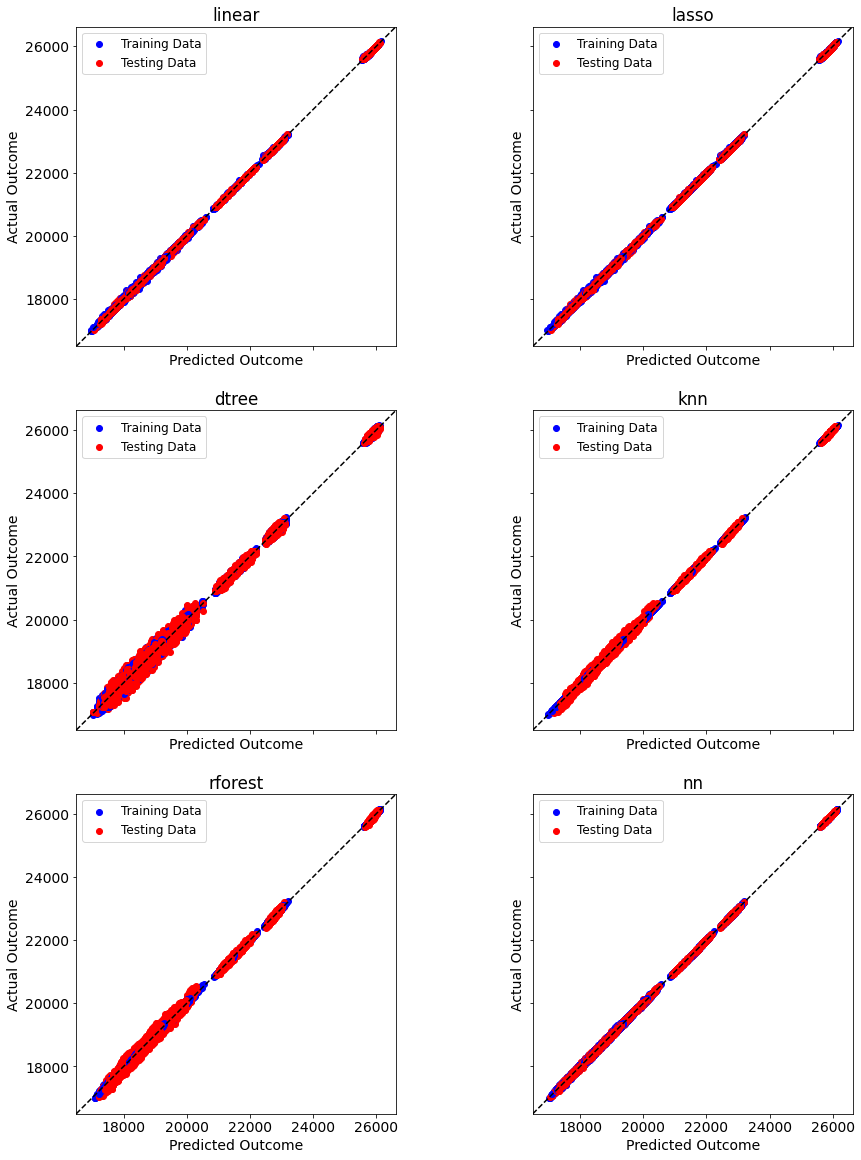

In [21]:
models = np.array([["linear", "lasso"], ["dtree", "knn"], ["rforest", "nn"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.diagonal_validation_plot(model_type=models[i, j], yscaler=preprocessor.yscaler)
        axarr[i, j].set_title(models[i, j])

All models display close spread to $y=x$; however, the lack of performance in `dtree` and `rforest` are apparent in the larger spread. 

Validation plots show the absolute error of the predicted output relative to the actual outputs of the testing data set. The function can evaluate all output or show just what is given in a list. This list can include column positions in the data set or the output names. For the validation plot below only the A-2, B-8, and C-8 fuel elements are shown.

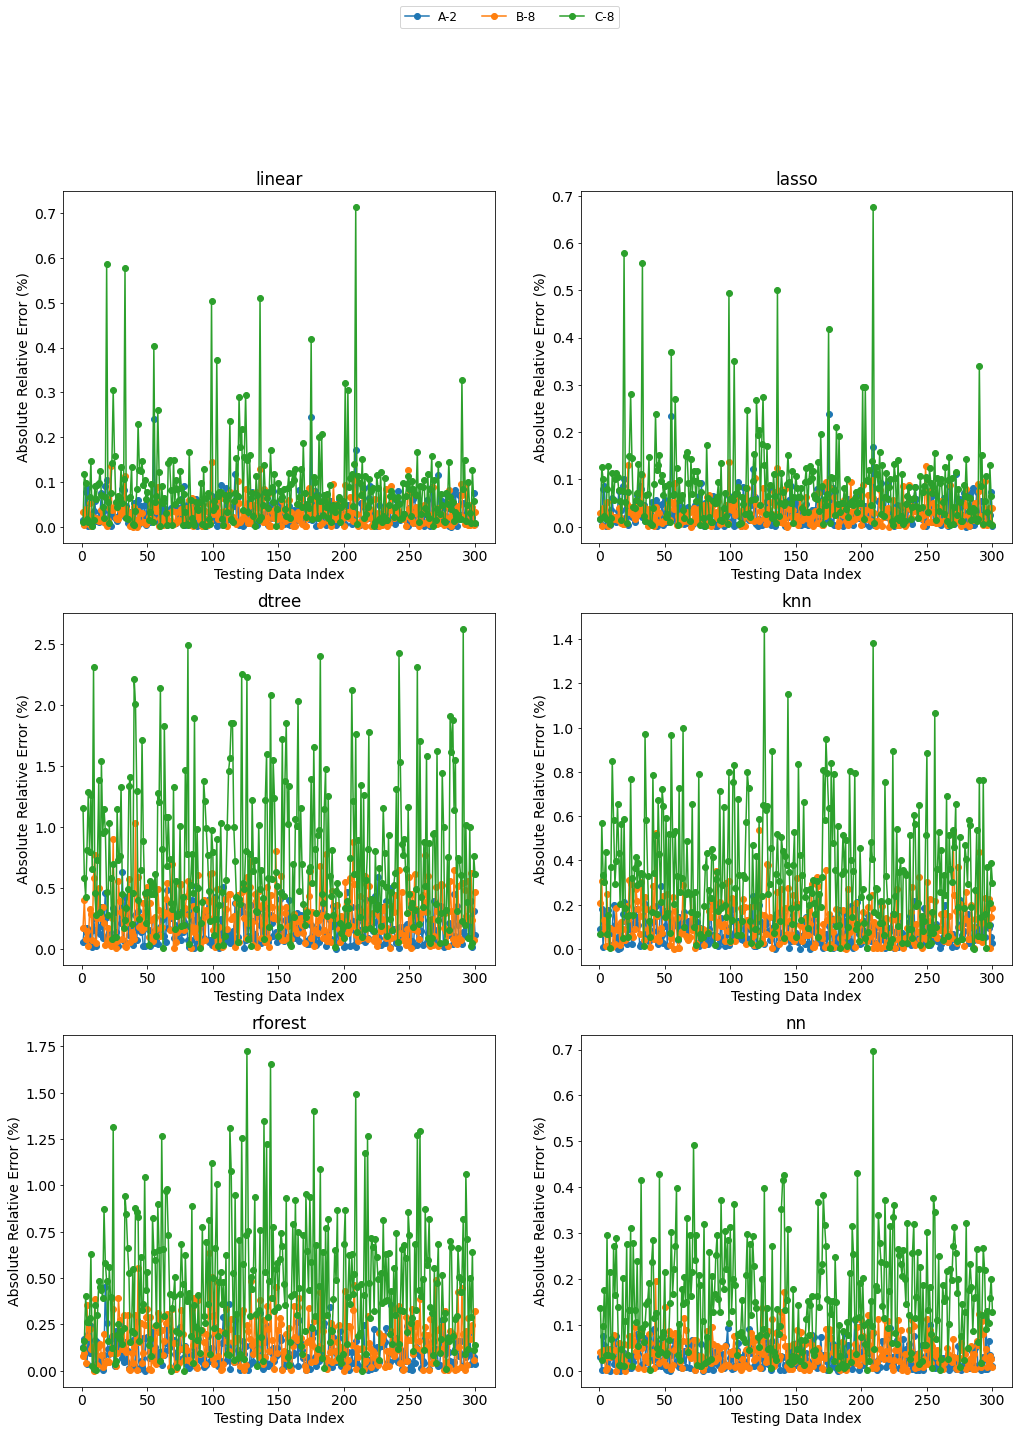

In [22]:
fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

y = ["A-2", "B-8", "C-8"]
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j], y=y, yscaler=preprocessor.yscaler)
        axarr[i, j].set_title(models[i, j])
        axarr[i, j].get_legend().remove()

fig.legend(y, loc="upper center", ncol=4)

The diagonal validation and validation plots agree with the performance metrics. The errors of `rforest` or `dtree` is higher than `linear`, `lasso`, `nn`, and `knn`.

To further understand the behavior of the top neural network configurations we can plot the learning curve. Here the top neural network learning curve is shown but, similar to the `diagonal_validation_plot` and `validation_plot` functions, `nn_learning_plot` shows the neural network based on the index in `metrics` or, if no index is provided, the one with the best test $R^2$.

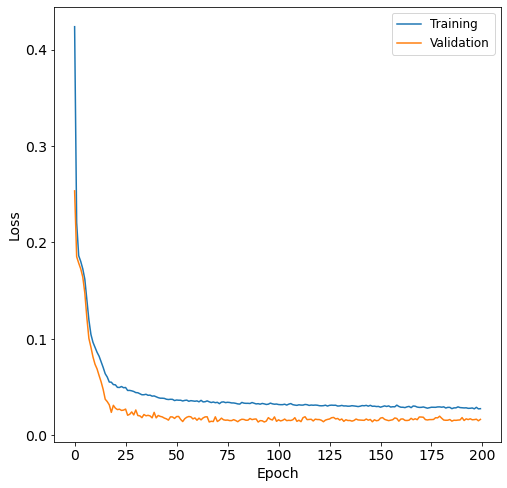

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
ax = postprocessor.nn_learning_plot()

The validation curve is below the training for the each epoch; therefore, the top neural networks configuration is not overfit to the training data.

Finally, using the linear regression model we can generate a predicted power for each fuel element given the
control blade heights.

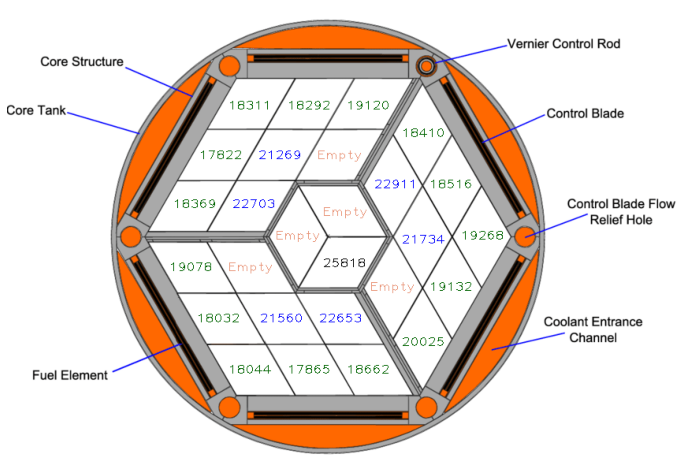

In [24]:
def plot_mitr(model, x, yscaler=None):
    pos=[(400,330), (465,230), (500,300), (395,400), (320,400), (285,255), (318,193),
         (500,165), (535,230), (575,295), (535,360), (500,430), (430,465), (355,465), 
         (280,465), (240,400), (205,335), (210,255), (243,193), (280,130), (355,130), 
         (430,130), (393,193), (460,360), (280,335), (400,265), (340,295)]
    
    Ynn=model.predict(np.array([x,]))
    if yscaler:
        Ynn=yscaler.inverse_transform(Ynn)
    Ynn=Ynn.flatten().tolist()
    
    image = cv2.imread("./supporting/mitr.png")
    for i in range(len(pos)):
        if i==0:
            image=cv2.putText(img=np.copy(image), text=str(int(Ynn[i])), org=pos[i], fontFace=1, fontScale=1.1, color=(0,0,0))
        if i in [1,2,3,4,5,6]:
            image=cv2.putText(img=np.copy(image), text=str(int(Ynn[i])), org=pos[i], fontFace=1, fontScale=1.1, color=(0,0,255)) 
        if i in list(range(7,22)):
            image=cv2.putText(img=np.copy(image), text=str(int(Ynn[i])), org=pos[i], fontFace=1, fontScale=1.1, color=(0, 100, 0)) 
        if i in list(range(22,28)):
            image=cv2.putText(img=np.copy(image), text=str('Empty'), org=pos[i], fontFace=1, fontScale=1.1, color=(233, 150, 122))            
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    plt.axis('off')

x=[0.75266553, 0.90280633, 0.00539489, 0.25308624, 0.57678792, 0.77792903]

plot_mitr(postprocessor.get_model(model_type="linear"), x, preprocessor.yscaler)

## References

1. M. I. RADAIDEH, K. DU, P. SEURIN, D. SEYLER, X. GU, H. WANG, and K. SHIRVAN, “NEORL: NeuroEvolution Optimization with Reinforcement Learning,” CoRR, abs/2112.07057 (2021).
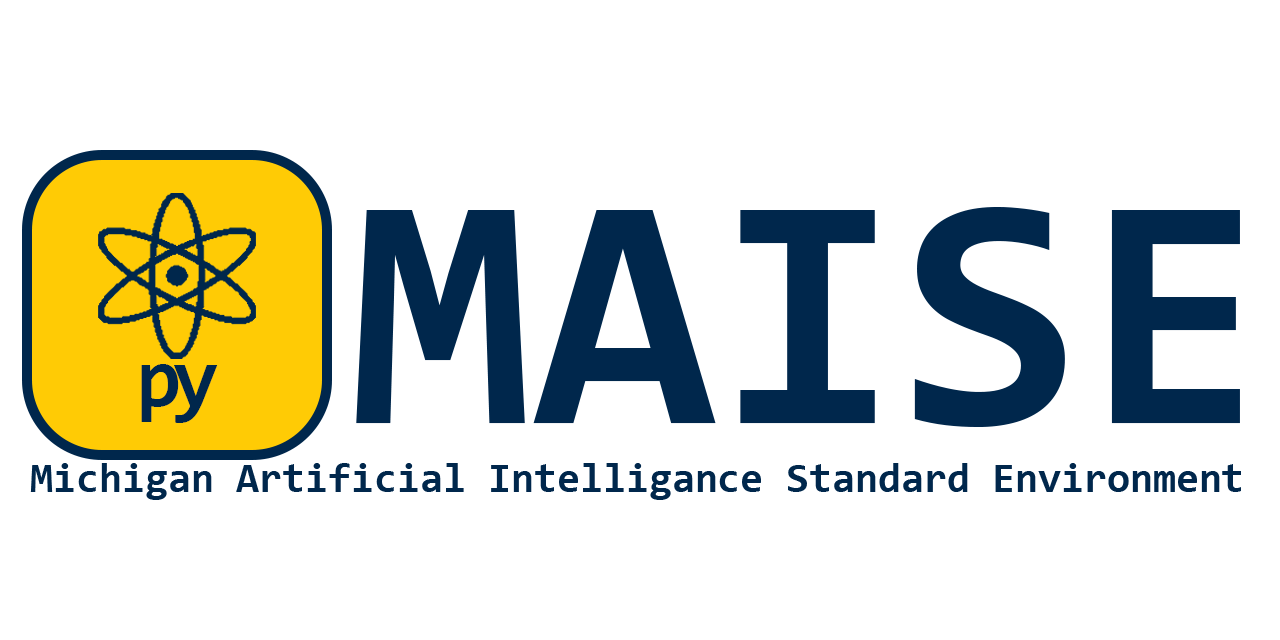